# The solution path of SLOPE

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

## Functions

In [2]:
def sorted_L1_norm(x,Lambda):
    x = - np.sort(-np.abs(x))  # x sorted by decreasing absolute value 
    return np.sum(Lambda*x)

def dual_sorted_L1_norm(v,Lambda):
    v = - np.sort(-np.abs(v)) # v sorted by decreasing absolute value 
    v_cum = np.cumsum(v)  # cumulative sum of v
    Lambda_cum = np.cumsum(Lambda) # cumulative sum of Lambda
    return np.max(v_cum/Lambda_cum)

def pattern(x, tol=1e-8):
    sign = np.sign(x)
    perm = np.argsort(-np.abs(x))
    x = np.abs(x)[perm]
    epsilon = min(tol*(x[0]-x[-1])/len(x), tol)
    jump = x - np.append(x[1:],0) > epsilon
    q = np.array([np.sum(jump[i:]) for i in range(len(x))])
    m = np.empty_like(x, dtype=int)
    m[perm] = q * sign[perm]
    return m

def face_pattern(v, Lambda, tol=1e-8):
    v = v / dual_sorted_L1_norm(v,Lambda)
    sign = np.sign(v)
    perm = np.argsort(-np.abs(v))
    v = np.abs(v)[perm]
    r = np.cumsum(v) / np.cumsum(Lambda)
    l = np.isclose(r, 1, rtol=tol)
    q = np.array([np.sum(l[i:]) for i in range(len(v))])
    m = np.empty_like(v, dtype=int)
    m[perm] = q * sign[perm]
    return m

def pattern_matrix(m):
    k = int(np.linalg.norm(m, ord=np.inf))
    U_m = np.empty((len(m),k))
    for j in range(k):
        U_m[:,j] = np.sign(m)*(np.abs(m) == k-j) 
    return U_m

def affine_components(X, y, Lambda, m):
    X_tilde = X @ pattern_matrix(m) # clustered matrix
    m = - np.sort(-np.abs(m)) # m sorted by decreasing absolute value
    Lambda_tilde = pattern_matrix(m).T @ Lambda # clustered parameter
    P = X_tilde.T @ X_tilde
    # s(gamma) = a_s * gamma + b_s
    a_s = - np.linalg.solve(P, Lambda_tilde)
    b_s = np.linalg.solve(P, X_tilde.T @ y)
    # g(gamma) = a_g * gamma + b_g
    a_g = - X.T @ X_tilde @ a_s
    b_g = X.T @ (y - X_tilde @ b_s)
    return a_s, b_s, a_g, b_g

def gamma_fuse(a_s, b_s, gamma, gamma_min = 0, epsilon=1e-8):
    a = np.append(a_s, 0)
    b = np.append(b_s, 0)
    Gamma = - (b[1:]- b[:-1]) / (a[1:] - a[:-1])
    return np.max(Gamma[(0 < Gamma) & (Gamma < gamma - epsilon)], initial=gamma_min)

def gamma_split(a_g, b_g, gamma, Lambda, epsilon=1e-8):
    K = np.array([True]); count = 0
    L_cum = np.cumsum(Lambda)
    while K.any():
        count += 1
        g = a_g * gamma + b_g
        sign = np.sign(g)
        perm = np.argsort(-np.abs(g))
        A_cum = np.cumsum(sign[perm]*a_g[perm])
        B_cum = np.cumsum(sign[perm]*b_g[perm])
        K = A_cum * gamma + B_cum - L_cum * gamma > epsilon
        gamma = np.max(B_cum[K] / (L_cum[K] - A_cum[K]), initial=gamma)
    return gamma, count > 1

def pattern_kinks(X, y, Lambda, ratio=1e-1, k_max=1e1, epsilon=1e-8):
    t_in = time.time()
    grad = X.T @ y
    gamma = dual_sorted_L1_norm(grad, Lambda); Gamma = [gamma]
    m = face_pattern(grad, Lambda, epsilon); M = [m]
    t_out = time.time(); T = [t_out - t_in]
    gamma_min = ratio*gamma; k = 0; Split = [True]
    print(f'kink {k} (time {t_out - t_in:.3f}s) : split, gamma = {gamma:.3f}, pattern = {m}')
    while gamma > gamma_min and k < k_max:
        k += 1
        a_s,b_s,a_g,b_g = affine_components(X, y, Lambda, m)
        gamma_f = gamma_fuse(a_s, b_s, gamma, gamma_min, epsilon)
        gamma_s, split = gamma_split(a_g, b_g, gamma_f, Lambda, epsilon)
        if split:
            gamma = gamma_s
            grad = a_g * gamma + b_g
            m = face_pattern(grad, Lambda, epsilon)
            t_out = time.time()
        else:
            gamma = gamma_f
            s = a_s * gamma + b_s
            z = pattern_matrix(m) @ s
            m = pattern(z, epsilon)
            t_out = time.time()
        print(f'kink {k} (time {t_out - t_in:.3f}s) : {"split" if split else "fuse"}, gamma = {gamma:.3f}, pattern = {m}')
        Gamma.append(gamma)
        M.append(m)
        T.append(t_out - t_in)
        Split.append(split)
    return Gamma, M, T, Split

def solution_kinks(X, y, Lambda, Gamma, M, Split):
    Sol = [np.zeros(X.shape[1])]
    for k, gamma in enumerate(Gamma[1:]):
        m = M[k] if Split[k+1] else M[k+1]
        a_s,b_s, *_ = affine_components(X, y, Lambda, m)
        s = a_s * gamma + b_s
        Sol.append(pattern_matrix(m) @ s)
    return Sol


## Toy example

In [3]:
X = np.array([[1, 0.5], [0.5,1]], dtype=float)
Lambda = np.array([4, 2], dtype=float)
y = np.array([6, 2], dtype=float)

kink 0 (time 0.000s) : split, gamma = 2.000, pattern = [1 1]
kink 1 (time 0.000s) : split, gamma = 1.000, pattern = [2 1]
kink 2 (time 0.001s) : fuse, gamma = 0.500, pattern = [1 0]
kink 3 (time 0.001s) : split, gamma = 0.115, pattern = [ 2 -1]
kink 4 (time 0.001s) : fuse, gamma = 0.000, pattern = [ 2 -1]


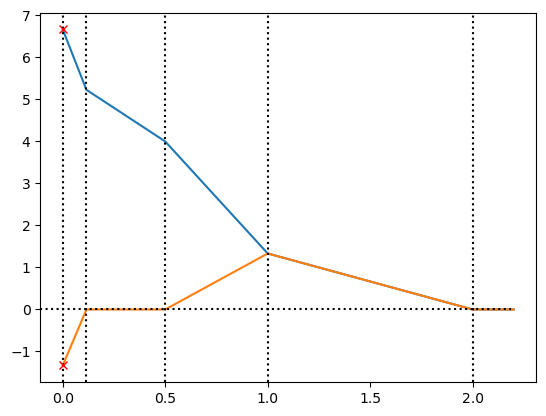

In [4]:
# Compute the kinks and the patterns on their left
Gamma, M, T, Split = pattern_kinks(X, y , Lambda, ratio=0, k_max=10)

# Compute the solutions at the kinks + ols
Sol = solution_kinks(X, y, Lambda, Gamma, M, Split)
ols = np.linalg.solve(X.T@X, X.T@y)

# Plot the solution path + ols
fig, ax = plt.subplots()
ax.plot([1.1*Gamma[0]] + Gamma, [Sol[0]] + Sol)
for gamma in Gamma:
    ax.axvline(gamma, color='k', linestyle=':')
ax.axhline(0, color='k', linestyle=':', xmax=0.95)
ax.plot(0, [ols], 'rx')
ax.set_xscale('linear') # 'linear', 'symlog', 'log'
plt.show() 

## `Wine quality` data set

The data set can be downloaded from <http://archive.ics.uci.edu/ml/datasets/Wine+Quality>.

In [5]:
# Load the data set
wine = pd.read_csv("winequality-red.csv", sep=';')
data = wine.drop(columns=['quality'])
target = wine['quality']

# Normalize X
X = data.to_numpy()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0, ddof=1)
X = (X - X_mean) / X_std

y = target.to_numpy()

Lambda = np.arange(X.shape[-1], 0, -1)

kink 0 (time 0.000s) : split, gamma = 55.863, pattern = [0 0 0 0 0 0 0 0 0 0 1]
kink 1 (time 0.001s) : split, gamma = 48.838, pattern = [ 0 -1  0  0  0  0  0  0  0  0  2]
kink 2 (time 0.002s) : split, gamma = 28.475, pattern = [ 0 -2  0  0  0  0  0  0  0  1  3]
kink 3 (time 0.002s) : split, gamma = 18.897, pattern = [ 0 -3  0  0  0  0 -1  0  0  2  4]
kink 4 (time 0.003s) : split, gamma = 17.793, pattern = [ 1 -4  1  0 -1 -1 -2 -1 -1  3  5]
kink 5 (time 0.003s) : split, gamma = 17.013, pattern = [ 2 -5  2  0 -2 -1 -3 -1 -2  4  6]
kink 6 (time 0.004s) : split, gamma = 15.791, pattern = [ 3 -6  3  0 -3 -1 -4 -2 -3  5  7]
kink 7 (time 0.004s) : fuse, gamma = 15.720, pattern = [ 2 -5  2  0 -2  0 -3 -1 -2  4  6]
kink 8 (time 0.004s) : split, gamma = 13.235, pattern = [ 2 -6  2  0 -3  0 -4 -1 -2  5  7]
kink 9 (time 0.005s) : fuse, gamma = 11.212, pattern = [ 1 -5  1  0 -2  0 -3 -1 -1  4  6]
kink 10 (time 0.005s) : split, gamma = 10.792, pattern = [ 2 -6  1  0 -3  0 -4 -1 -1  5  7]
kink 11 (ti

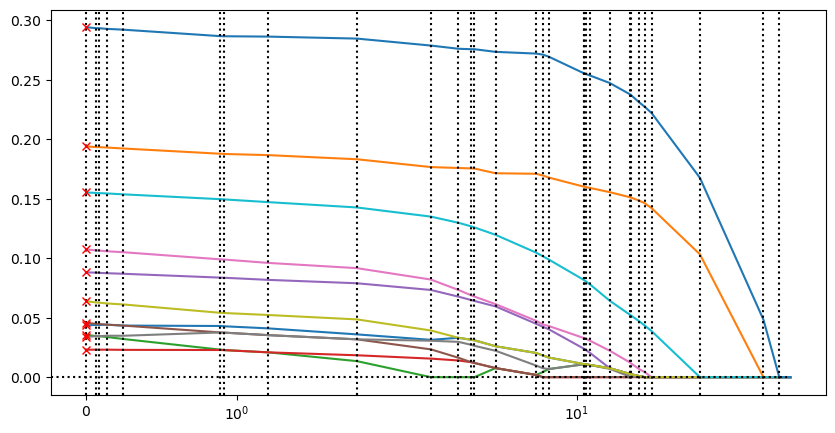

In [6]:
# Compute the kinks and the patterns on their left
Gamma, M, T, Split = pattern_kinks(X, y , Lambda, ratio=0, k_max=1e2)

# Compute the solutions at the kinks + ols and their absolute values
Sol = solution_kinks(X, y, Lambda, Gamma, M, Split)
Sol_abs = [np.abs(sol) for sol in Sol]
ols = np.linalg.solve(X.T@X, X.T@y)
ols_abs = np.abs(ols)

# Plot the absolute solution path + ols
fig, ax = plt.subplots(figsize=(10,5))
ax.plot([1.1*Gamma[0]] + Gamma, [Sol[0]] + Sol_abs)
for gamma in Gamma:
    ax.axvline(gamma, color='k', linestyle=':')
ax.axhline(0, color='k', linestyle=':', xmax=0.95)
ax.plot(0, [np.abs(ols)], 'rx')
ax.set_xscale('symlog')
plt.show()